# 確率ロボティクス2016第3回

上田隆一

2016年10月4日@千葉工業大学

## モンテカルロ法による$bel$の計算

* 発想: 前回の移動ロボットのシミュレーションをロボット（エージェント）が行う。
  * 一挙にたくさん並列で
  * 状態遷移のシミュレーション
* 一つ時刻0の状態$\boldsymbol{x}_0$を選んで、制御出力に合わせて移動
  * 誤差を混入
* 一つのシミュレーションの状態を、$bel$からサンプリングされる標本（サンプル）とみなすことができる
  * 「粒子（パーティクル）」という言い方も

## モンテカルロ法のプログラミング

* 前回の移動ロボットの動作をふまえて
  * 実際のロボットの動き（のシミュレーションを作る）
  * パーティクルの動きを作る
    * 数は100個にしましょう。

### まず変数を準備

In [1]:
%matplotlib inline
import numpy as np
from copy import copy
import math, random
import matplotlib.pyplot as plt                   #   for plotting data
from matplotlib.patches import Ellipse      #  for drawing

### 変数 ###

# 実際の世界のシミュレーション
actual_x = np.array([0.0,0.0,0.0])   #ロボットの実際の姿勢
u = np.array([0.2,math.pi / 180.0 * 20]) #ロボットの移動

# モンテカルロ法のための変数
class Particle:
    def __init__(self,w):
        self.pose = np.array([0.0,0.0,0.0])
        self.weight = w
    
    def __repr__(self):
        return "pose: " + str(self.pose) + " weight: " + str(self.weight)
        
particles = [Particle(1.0/100) for i in range(100)]

In [2]:
# 一個プリントしてみましょう
print(particles[0])

pose: [ 0.  0.  0.] weight: 0.01


### ロボットとパーティクルを動かす関数

前回のをコピペ

In [3]:
def f(x_old,u):
    pos_x, pos_y, pos_theta = x_old
    act_fw, act_rot = u
    
    act_fw = random.gauss(act_fw,act_fw/10)
    dir_error = random.gauss(0.0, math.pi / 180.0 * 3.0)
    act_rot = random.gauss(act_rot,act_rot/10)
    
    pos_x += act_fw * math.cos(pos_theta + dir_error)
    pos_y += act_fw * math.sin(pos_theta + dir_error)
    pos_theta += act_rot
    
    return np.array([pos_x,pos_y,pos_theta])

これで準備OK

### 動作の確認

In [4]:
import copy

path = [actual_x]
particle_path = [copy.deepcopy(particles)]
for i in range(10):
    actual_x = f(actual_x,u)
    path.append(actual_x)
    
    for p in particles:
        p.pose = f(p.pose,u)
    particle_path.append(copy.deepcopy(particles))

#### 値の確認

In [5]:
print(path[0])
print(particle_path[0])

print(path[10])
print(particle_path[10])

[ 0.  0.  0.]
[pose: [ 0.  0.  0.] weight: 0.01, pose: [ 0.  0.  0.] weight: 0.01, pose: [ 0.  0.  0.] weight: 0.01, pose: [ 0.  0.  0.] weight: 0.01, pose: [ 0.  0.  0.] weight: 0.01, pose: [ 0.  0.  0.] weight: 0.01, pose: [ 0.  0.  0.] weight: 0.01, pose: [ 0.  0.  0.] weight: 0.01, pose: [ 0.  0.  0.] weight: 0.01, pose: [ 0.  0.  0.] weight: 0.01, pose: [ 0.  0.  0.] weight: 0.01, pose: [ 0.  0.  0.] weight: 0.01, pose: [ 0.  0.  0.] weight: 0.01, pose: [ 0.  0.  0.] weight: 0.01, pose: [ 0.  0.  0.] weight: 0.01, pose: [ 0.  0.  0.] weight: 0.01, pose: [ 0.  0.  0.] weight: 0.01, pose: [ 0.  0.  0.] weight: 0.01, pose: [ 0.  0.  0.] weight: 0.01, pose: [ 0.  0.  0.] weight: 0.01, pose: [ 0.  0.  0.] weight: 0.01, pose: [ 0.  0.  0.] weight: 0.01, pose: [ 0.  0.  0.] weight: 0.01, pose: [ 0.  0.  0.] weight: 0.01, pose: [ 0.  0.  0.] weight: 0.01, pose: [ 0.  0.  0.] weight: 0.01, pose: [ 0.  0.  0.] weight: 0.01, pose: [ 0.  0.  0.] weight: 0.01, pose: [ 0.  0.  0.] weight: 0.01,

### 描画

In [6]:
def draw(pose,particles):    
    fig = plt.figure(i,figsize=(8, 8))
    sp = fig.add_subplot(111, aspect='equal')
    sp.set_xlim(-1.0,1.0)
    sp.set_ylim(-0.5,1.5)
    
    xs = [e.pose[0] for e in particles]
    ys = [e.pose[1] for e in particles]
    vxs = [math.cos(e.pose[2]) for e in particles]
    vys = [math.sin(e.pose[2]) for e in particles]
    plt.quiver(xs,ys,vxs,vys,color="blue",label="particles")
    
    plt.quiver([pose[0]],[pose[1]],[math.cos(pose[2])],[math.sin(pose[2])],color="red",label="actual robot motion")

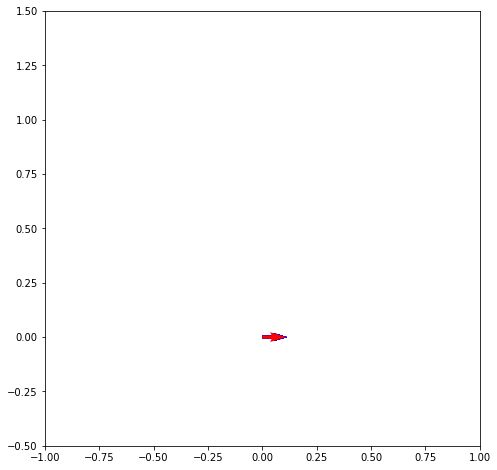

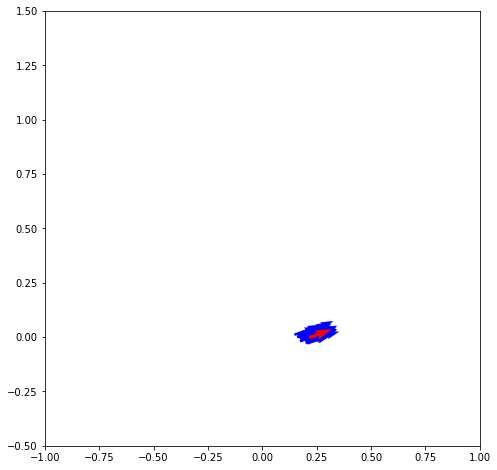

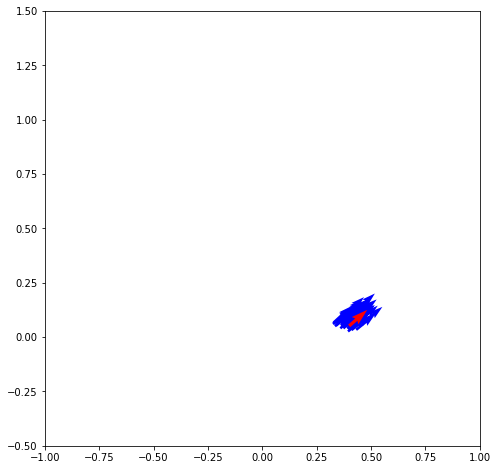

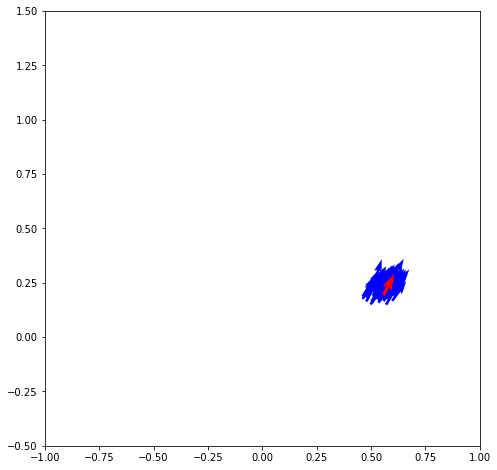

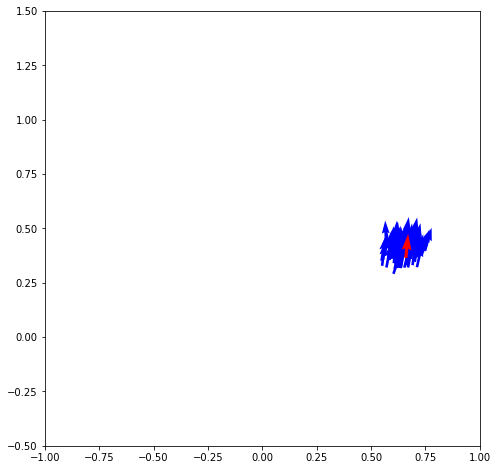

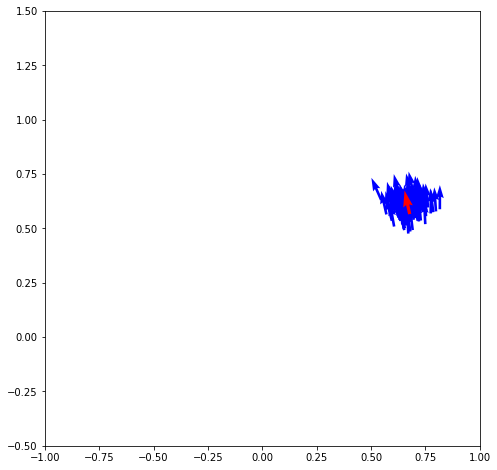

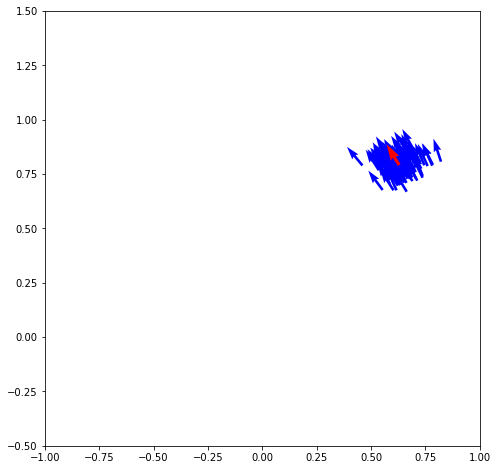

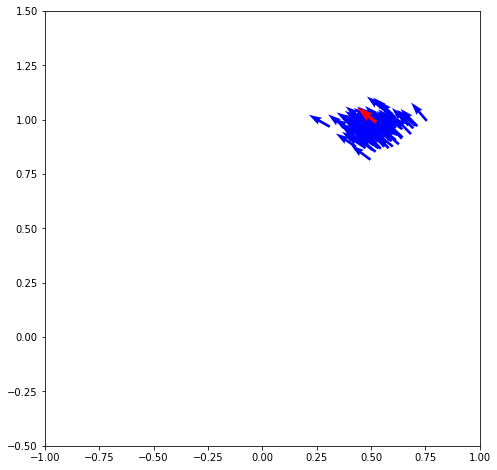

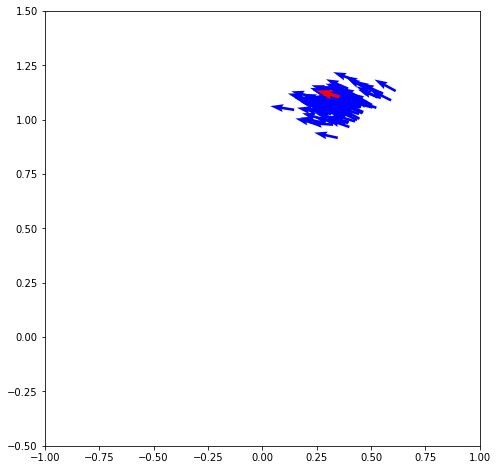

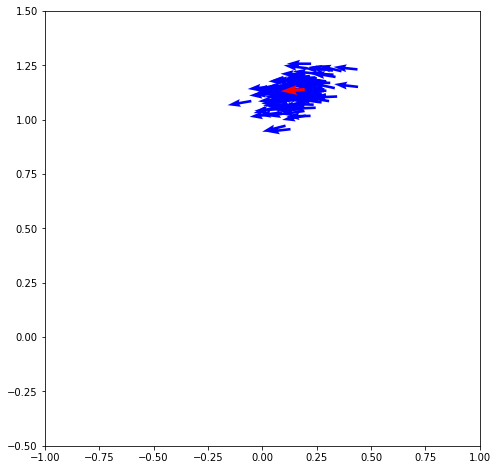

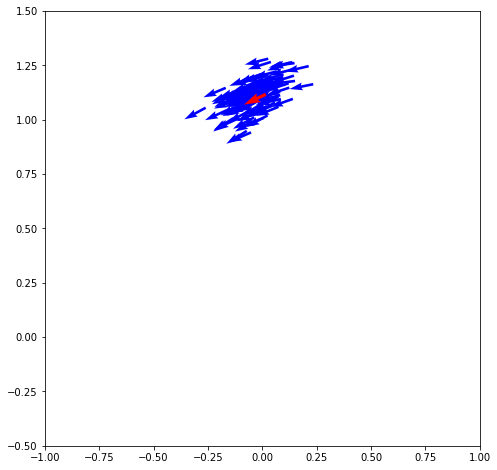

In [7]:
for i,p in enumerate(path):
    draw(path[i],particle_path[i])

## 数式での表現

### パーティクルの定義

* $\Xi = \{\xi^{(i)} = (\boldsymbol{x}^{(i)}, w^{(i)}) | i = 1,2,\dots,N \}$
* パーティクルは次のように$bel$を近似しなければならない
  * $Bel(X) = \int_{\boldsymbol{x} \in X} bel(\boldsymbol{x}) d\boldsymbol{x} \approx \sum_{i=1}^N \delta(\boldsymbol{x}^{(i)} \in X) w^{(i)}$
   * $Bel(X)$: $X$の中に真の状態が存在する確率
     * 密度関数$bel$を積分すると確率になる
   * $\forall X \subset \mathcal{X}$ 
   * $\delta$: カッコの中が真なら1、そうでなければ0


### motion update

* 先ほどのシミュレーション
* 各パーティクルを$p(\boldsymbol{x} | \boldsymbol{x}_{t-1}, \boldsymbol{u}_t)$に従って動かす
  * $\boldsymbol{x}^{(i)}_t \sim p(\boldsymbol{x} | \boldsymbol{x}_{t-1}, \boldsymbol{u}_t) \quad (i=1,2,\dots,N)$
    * 時刻$t$における$i$番目のパーティクルの状態を、状態遷移の確率分布にしたがって一つランダムに選ぶ
    * 今のところ、全パーティクルをひとつずつ選んで動かすだけでよい

## まとめ

* $bel$をモンテカルロ法（パーティクル）で近似計算
* ロボットの動きを雑音つきの状態方程式で表現してロボットに実装
* ロボットの中でパーティクルの数だけロボットの動作のシミュレーション